In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import preprocessing, utils
import os
import yaml

# Retrieve data train

In [2]:
knowledgebase = pd.read_excel('https://raw.githubusercontent.com/AndiAlifs/FLUENT-Chatbot-2023/main/KnowledgeBaseFilkom.xlsx', engine='openpyxl')
knowledgebase.head()

,No,Contributor,Topik/Tag,Pertanyaan,Jenis,Jawaban,Link Jawaban,Keterangan Tambahan
0,0.0,Fitra,Informasi Dosen,email Fitra A. Bachtiar,Statis,fitra.bachtiar[at]ub.ac.id,https://filkom.ub.ac.id/sdm-dosen/?search_f7a8...,NaN
1,NaN,NaN,NaN,NIK/NIP Fitra A. Bachtiar,Statis,198406282019031006,NaN,NaN
2,NaN,NaN,NaN,nama lengkap Fitra A. Bachtiar,Statis,Dr.Eng. Fitra A. Bachtiar,https://filkom.ub.ac.id/sdm-dosen/?search_f7a8...,NaN
3,NaN,NaN,NaN,Departemen Fitra A. Bachtiar,Dinamis,Departemen Teknik Informatika,https://filkom.ub.ac.id/sdm-dosen/?search_f7a8...,NaN
4,NaN,NaN,NaN,Program Studi Fitra A. Bachtiar,Dinamis,S2 Ilmu Komputer,https://filkom.ub.ac.id/sdm-dosen/?search_f7a8...,NaN


In [3]:
qa_paired = knowledgebase.drop(columns=knowledgebase.columns.drop(['Pertanyaan', 'Jawaban']))
qa_paired.dropna(inplace=True)
qa_paired

,Pertanyaan,Jawaban
0,email Fitra A. Bachtiar,fitra.bachtiar[at]ub.ac.id
1,NIK/NIP Fitra A. Bachtiar,198406282019031006
2,nama lengkap Fitra A. Bachtiar,Dr.Eng. Fitra A. Bachtiar
3,Departemen Fitra A. Bachtiar,Departemen Teknik Informatika
4,Program Studi Fitra A. Bachtiar,S2 Ilmu Komputer
...,...,...
1229,Apa Manfaat Konseling FILKOM ?,1. Masalah ditangani oleh ahli yang kompeten d...
1230,Berikan informasi mengenai Layanan Konseling,Informasi mengenai Layanan Konseling dapat dia...
1231,Siapa Konselor Bimbingan dan Konseling di FILK...,Ada 2 konselor Bimbingan dan Konseling di FILK...
1232,Siapa Koordinator Konselor Sebaya ?,Koordinator Konselor Sebaya adalah Muhammad Da...


# RNN Based

## Preprocessing Data

In [5]:
# remove all the punctuation from qa_paired
qa_paired['Pertanyaan'] = qa_paired['Pertanyaan'].str.replace('[^\w\s]',' ').str.lower()
qa_paired['Jawaban'] = qa_paired['Jawaban'].str.replace('[^\w\s]',' ').str.lower()

In [6]:
vocab = sorted(set(" ".join(qa_paired['Pertanyaan'] +" " + qa_paired['Jawaban']).split()))

In [8]:
questions = qa_paired['Pertanyaan']

answers = list()
for i in range( len(qa_paired['Jawaban']) ) :
    answers.append( '<START> ' + " ".join(qa_paired['Jawaban'].iloc[i].split()) + ' <END>' )

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts( questions + answers )
VOCAB_SIZE = len( tokenizer.word_index )+1
print( 'VOCAB SIZE : {}'.format( VOCAB_SIZE ))

VOCAB SIZE : 2600


### Encoder-Decoder

In [9]:
from gensim.models import Word2Vec
import re

In [10]:
vocab = []
for word in tokenizer.word_index:
  vocab.append(word)

def tokenize(sentences):
  tokens_list = []
  vocabulary = []
  for sentence in sentences:
    sentence = sentence.lower()
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    tokens = sentence.split()
    vocabulary += tokens
    tokens_list.append(tokens)
  return tokens_list, vocabulary

In [11]:
#encoder_input_data
tokenized_questions = tokenizer.texts_to_sequences( questions )
maxlen_questions = max( [len(x) for x in tokenized_questions ] )
padded_questions = preprocessing.sequence.pad_sequences( tokenized_questions, maxlen = maxlen_questions, padding = 'post')
encoder_input_data = np.array(padded_questions)
print(encoder_input_data.shape, maxlen_questions)

(1198, 13) 13


In [12]:
# decoder_input_data
tokenized_answers = tokenizer.texts_to_sequences( answers )
maxlen_answers = max( [ len(x) for x in tokenized_answers ] )
padded_answers = preprocessing.sequence.pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )
decoder_input_data = np.array( padded_answers )
print( decoder_input_data.shape , maxlen_answers )

(1198, 294) 294


In [13]:
# decoder_output_data
tokenized_answers = tokenizer.texts_to_sequences( answers )
for i in range(len(tokenized_answers)) :
    tokenized_answers[i] = tokenized_answers[i][1:]
padded_answers = preprocessing.sequence.pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )
onehot_answers = utils.to_categorical( padded_answers , VOCAB_SIZE )
decoder_output_data = np.array( onehot_answers )
print( decoder_output_data.shape )

(1198, 294, 2600)


## Modelling

In [14]:
encoder_inputs = tf.keras.layers.Input(shape=( maxlen_questions , ))
encoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 200 , mask_zero=True ) (encoder_inputs)
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM( 200 , return_state=True )( encoder_embedding )
encoder_states = [ state_h , state_c ]

decoder_inputs = tf.keras.layers.Input(shape=( maxlen_answers ,  ))
decoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 200 , mask_zero=True) (decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM( 200 , return_state=True , return_sequences=True )
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
decoder_dense = tf.keras.layers.Dense( VOCAB_SIZE , activation=tf.keras.activations.softmax ) 
output = decoder_dense ( decoder_outputs )

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='categorical_crossentropy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 294)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 13, 200)      520000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 294, 200)     520000      input_2[0][0]                    
______________________________________________________________________________________________

In [16]:
history = model.fit([encoder_input_data , decoder_input_data], decoder_output_data, batch_size=50, epochs=50 ) 
# model.save( 'model.h5' )

Epoch 1/50
24/24 [==============================] - 20s 802ms/step - loss: 0.4177
Epoch 2/50
24/24 [==============================] - 20s 818ms/step - loss: 0.4017
Epoch 3/50
24/24 [==============================] - 19s 772ms/step - loss: 0.3880
Epoch 4/50
24/24 [==============================] - 18s 769ms/step - loss: 0.3745
Epoch 5/50
24/24 [==============================] - 19s 788ms/step - loss: 0.3608
Epoch 6/50
24/24 [==============================] - 18s 759ms/step - loss: 0.3459
Epoch 7/50
24/24 [==============================] - 19s 783ms/step - loss: 0.3326
Epoch 8/50
24/24 [==============================] - 19s 773ms/step - loss: 0.3203
Epoch 9/50
24/24 [==============================] - 19s 770ms/step - loss: 0.3100
Epoch 10/50
24/24 [==============================] - 19s 781ms/step - loss: 0.3002
Epoch 11/50
24/24 [==============================] - 19s 780ms/step - loss: 0.2909
Epoch 12/50
24/24 [==============================] - 19s 777ms/step - loss: 0.2831
Epoch 13/50
2

<AxesSubplot:>

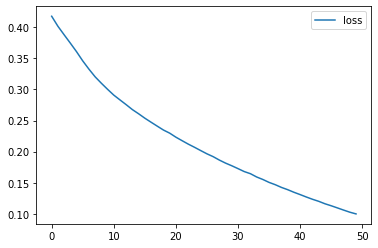

In [23]:
visualization = pd.DataFrame(history.history)
visualization[['loss']].plot()

## Test the chatbot

In [17]:
def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 200 ,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 200 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    
    decoder_states = [state_h, state_c]

    decoder_outputs = decoder_dense(decoder_outputs)
    
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model

In [18]:
def str_to_tokens( sentence : str ):

    words = sentence.lower().split()
    tokens_list = list()

    for word in words:
        tokens_list.append( tokenizer.word_index[ word ] ) 
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=maxlen_questions , padding='post')


In [22]:
# disable warning tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'

enc_model , dec_model = make_inference_models()

quest = input("Enter question : ")

states_values = enc_model.predict( str_to_tokens(quest) )
empty_target_seq = np.zeros( ( 1 , 1 ) )
empty_target_seq[0, 0] = tokenizer.word_index['start']
stop_condition = False
decoded_translation = ''
while not stop_condition :
    dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
    sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
    sampled_word = None
    for word , index in tokenizer.word_index.items() :
        if sampled_word_index == index :
            decoded_translation += ' {}'.format( word )
            sampled_word = word
    
    if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
        stop_condition = True
        
    empty_target_seq = np.zeros( ( 1 , 1 ) )  
    empty_target_seq[ 0 , 0 ] = sampled_word_index
    states_values = [ h , c ] 

print("Pertanyaan : ", quest)
print("Jawaban : ", decoded_translation)

Pertanyaan :  email fitra bachtiar
Jawaban :   m aminul at ub ac id end
